<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Deep Learning Based Strategy

How to predict Stocks Returns with Neuronal Networks

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

In [9]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2020-07-01", end="2020-07-25", interval = "5m")

[*********************100%***********************]  1 of 1 completed


In [10]:
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

In [11]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1326 entries, 2020-07-01 09:30:00-04:00 to 2020-07-28 09:43:21-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1326 non-null   float64
dtypes: float64(1)
memory usage: 20.7 KB


In [12]:
data = rawdata.copy()
data['returns'] = np.log(data/data.shift(1))
data['direction'] = np.where(data['returns'] > 0 , 1,0)


# Calculates Simple Moving Averages with a long and a short window
data['SMA1'] = data['price'].rolling(20).mean().shift(1)
data['SMA2'] = data['price'].rolling(60).mean().shift(1)
data['dSMA'] = data['SMA1'] - data['SMA2']

# Calculates Equally Weighted Moving Average with a long and a short halflife
data['EWMA1'] = data['price'].ewm(halflife=20).mean().shift(1)
data['EWMA2'] = data['price'].ewm(halflife=60).mean().shift(1)
data['dEWMA'] = data['EWMA1'] - data['EWMA2']

# Calculates the moving standard deviation
data['vol1'] = data['price'].rolling(20).std().shift(1)
data['vol2'] = data['price'].rolling(60).std().shift(1)

# Deletes NA rows
data.dropna(inplace=True)

data.head()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
Datetime,,,,,,,,,,,
2020-07-01 14:30:00-04:00,205.690002,-0.000049,0,205.073505,204.542465,0.531039,204.902730,204.676513,0.226217,0.521942,0.848835
2020-07-01 14:35:00-04:00,205.550095,-0.000680,0,205.123505,204.586577,0.536928,204.933230,204.699530,0.233699,0.531088,0.838313
2020-07-01 14:40:00-04:00,205.440002,-0.000536,0,205.163010,204.640412,0.522598,204.957017,204.718633,0.238384,0.532010,0.792769
2020-07-01 14:45:00-04:00,205.529999,0.000438,1,205.210260,204.676532,0.533728,204.975558,204.734658,0.240899,0.511113,0.778647
2020-07-01 14:50:00-04:00,205.600006,0.000341,1,205.277760,204.723032,0.554729,204.996750,204.752140,0.244611,0.453823,0.743557


In [13]:
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [14]:
train.shape

(886, 11)

In [15]:
test.shape

(380, 11)

In [16]:
features = list(data.columns)
cols = list(data.columns)
for f in features:    
    #Create lags
    for lag in range(1, 5 + 1):
        col = f'{f}_lag_{lag}'
        cols.append(col)
        train[col] = train[f].shift(lag)
        test[col] = test[f].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)   

#Normalizes variables
for f in cols:    
    if 'rets' not in f and 'direction' not in f:
        Tmean = train[f].mean()
        Tstd  = train[f].std()
        train[f]= (train[f] - Tmean) / Tstd
        test[f] = (test[f]  - Tmean) / Tstd    

In [17]:
y_train = pd.DataFrame(train['direction'])
y_test = pd.DataFrame(test['direction'])
X_train = train.drop(columns=['direction','returns','price']).copy()
X_test = test.drop(columns=['direction','returns','price']).copy()

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2020-07-01 14:55:00-04:00 to 2020-07-20 10:20:00-04:00
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMA1             881 non-null    float64
 1   SMA2             881 non-null    float64
 2   dSMA             881 non-null    float64
 3   EWMA1            881 non-null    float64
 4   EWMA2            881 non-null    float64
 5   dEWMA            881 non-null    float64
 6   vol1             881 non-null    float64
 7   vol2             881 non-null    float64
 8   price_lag_1      881 non-null    float64
 9   price_lag_2      881 non-null    float64
 10  price_lag_3      881 non-null    float64
 11  price_lag_4      881 non-null    float64
 12  price_lag_5      881 non-null    float64
 13  returns_lag_1    881 non-null    float64
 14  returns_lag_2    881 non-null    float64
 15  returns_lag_3    881 non-null    float64
 16  returns_lag_4

In [19]:
split = int(len(X_train) * 0.7)
partial_X_train = X_train.iloc[split:].copy()
X_val = X_train.iloc[:split].copy()
partial_y_train = y_train.iloc[split:].copy()
y_val = y_train.iloc[:split].copy()

In [20]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [37]:
def create_model():
  
    model = Sequential()
    
    model.add(Dense(64, input_dim=63, activation='relu'))
#    model.add(Dense(128, activation='relu'))  
        
    model.add(Dense(1, activation='sigmoid'))  
    
    model.compile(loss='binary_crossentropy',  
                           optimizer='adam',  
                           metrics=['acc'])  
    return model

In [38]:
model = create_model()

In [39]:
history = model.fit(partial_X_train, 
                          partial_y_train, 
                          epochs=20, 
                          verbose=False,
                          validation_data=(X_val,y_val))

In [40]:
#Returns the loss value & metrics values for the model in test mode.
model.evaluate(X_train, y_train)

881/881 [==============================] - 0s 52us/step


[0.7022278356903934, 0.5595913529396057]

In [41]:
accuracy_score(model.predict(X_test).round(), y_test)

0.5173333333333333

In [42]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

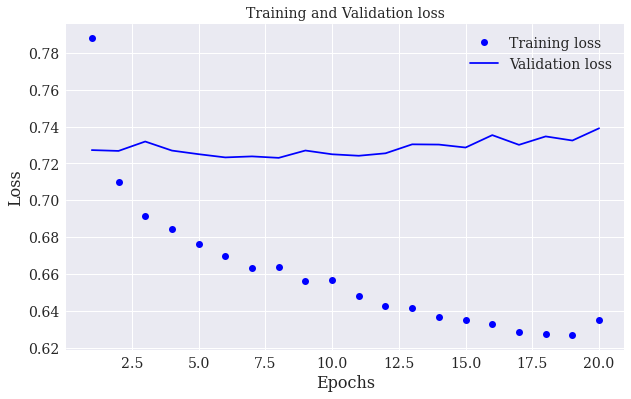

In [43]:
plt.plot(epochs, loss_values,'bo', label='Training loss')
plt.plot(epochs, val_loss_values,'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

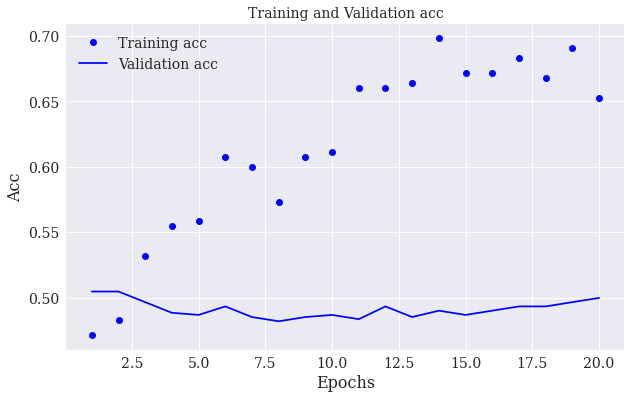

In [44]:
plt.plot(epochs, acc_values,'bo', label='Training acc')
plt.plot(epochs, val_acc_values,'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()